In [51]:
import matplotlib.pyplot as pl
import numpy as np
import pandas as pd
import xarray as xr
import math

from fair import FAIR
from fair.interface import fill, initialise
from fair.io import read_properties

D:\Conda\envs\test_env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Running Model with RCIMP

In [ ]:
f = FAIR(ch4_method="Thornhill2021")
f.define_time(1750, 2300, 1)  # start, end, step

"""
scenarios = [
    "high-extension",
    "high-overshoot",
    "medium-overshoot",
    "medium-extension",
    "low",
    "verylow",
    "verylow-overshoot",
]
"""

scenarios_Rcimp = ['ssp119', 'ssp126', 'ssp245', 'ssp370', 'ssp434', 'ssp460', 'ssp534-over', 'ssp585']
f.define_scenarios(scenarios_Rcimp)
fair_params_1_4_1_file = 'examples/data/calibrated_constrained_ensemble/calibrated_constrained_parameters_calibration1.4.1.csv'
df_configs = pd.read_csv(fair_params_1_4_1_file, index_col=0)
configs = df_configs.index  # this is used as a label for the "config" axis
f.define_configs(configs)
fair_species_configs_1_4_1_file = 'examples/data/calibrated_constrained_ensemble/species_configs_properties_calibration1.4.1.csv'
species_Rcimp, properties = read_properties(filename=fair_species_configs_1_4_1_file)
f.define_species(species_Rcimp, properties)
f.allocate()
"""
f.fill_from_csv(
    emissions_file='examples/data/calibrated_constrained_ensemble/extensions_1750-2500.csv',
    forcing_file='examples/data/calibrated_constrained_ensemble/volcanic_solar.csv',
)
"""
f.fill_from_rcmip()


f.forcing.sel(specie="Volcanic")
fill(
    f.forcing,
    f.forcing.sel(specie="Volcanic") * df_configs["forcing_scale[Volcanic]"].values.squeeze(),
    specie="Volcanic",
)
fill(
    f.forcing,
    f.forcing.sel(specie="Solar") * df_configs["forcing_scale[Solar]"].values.squeeze(),
    specie="Solar",
)
f.fill_species_configs(fair_species_configs_1_4_1_file)
f.override_defaults(fair_params_1_4_1_file)
initialise(f.concentration, f.species_configs["baseline_concentration"])
initialise(f.forcing, 0)
initialise(f.temperature, 0)
initialise(f.cumulative_emissions, 0)
initialise(f.airborne_emissions, 0)
initialise(f.ocean_heat_content_change, 0)
f.run()



Running model with data from calibrated ensenbles

In [ ]:
"""f2 = FAIR(ch4_method="Thornhill2021")
f2.define_time(1750, 2300, 1)  # start, end, step
scenarios_data = [
    "high-extension",
    "high-overshoot",
    "medium-overshoot",
    "medium-extension",
    "low",
    "verylow",
    "verylow-overshoot",
]
f2.define_scenarios(scenarios_data)
fair_params_1_4_1_file = 'examples/data/calibrated_constrained_ensemble/calibrated_constrained_parameters_calibration1.4.1.csv'
df_configs = pd.read_csv(fair_params_1_4_1_file, index_col=0)
configs = df_configs.index  # this is used as a label for the "config" axis
f2.define_configs(configs)
fair_species_configs_1_4_1_file = 'examples/data/calibrated_constrained_ensemble/species_configs_properties_calibration1.4.1.csv'
species_data, properties = read_properties(filename=fair_species_configs_1_4_1_file)
f2.define_species(species_data, properties)
f2.allocate()
f2.fill_from_csv(
    emissions_file='examples/data/calibrated_constrained_ensemble/extensions_1750-2500.csv',
    forcing_file='examples/data/calibrated_constrained_ensemble/volcanic_solar.csv',
)


f2.forcing.sel(specie="Volcanic")
fill(
    f2.forcing,
    f2.forcing.sel(specie="Volcanic") * df_configs["forcing_scale[Volcanic]"].values.squeeze(),
    specie="Volcanic",
)
fill(
    f2.forcing,
    f2.forcing.sel(specie="Solar") * df_configs["forcing_scale[Solar]"].values.squeeze(),
    specie="Solar",
)
f2.fill_species_configs(fair_species_configs_1_4_1_file)
f2.override_defaults(fair_params_1_4_1_file)
initialise(f2.concentration, f2.species_configs["baseline_concentration"])
initialise(f2.forcing, 0)
initialise(f2.temperature, 0)
initialise(f2.cumulative_emissions, 0)
initialise(f2.airborne_emissions, 0)
initialise(f2.ocean_heat_content_change, 0)
f2.run()"""



(for data in calibrated ensemble) Exporting Maximum Forcing for each specie under each scenario, and along with the year it occurs

In [ ]:
"""max_forcing_data = []
for scenario in scenarios_data:
    for specie in species_data:
        max_forcing = f2.forcing.loc[dict(scenario=scenario, specie=specie)].max().item()
        max_forcing_index = f2.forcing.loc[dict(scenario=scenario, specie=specie)].argmax(dim='timebounds')[0].item()
        max_forcing_year = f2.timebounds[max_forcing_index]
        max_forcing_data.append({
            'scenario': scenario,
            'specie': specie,
            'max_forcing': max_forcing,
            'max_forcing_year': max_forcing_year
        })
max_forcing_df = pd.DataFrame(max_forcing_data)
max_forcing_df.to_csv('examples/data/calibrated_constrained_ensemble/max_forcing_data.csv')
max_forcing_df"""

# Adding 4 new species for forcing calculation

- Finding max forcing, average each config, report STDV as error
- Writing into the Rcimp max forcing df
- ariNH3  shape=(550, 8, 841) (years, scenarios, configs)

In [ ]:
ariNH3 = np.zeros((np.size(f.timepoints),np.size(scenarios_Rcimp),np.size(configs)))
for i in range(np.size(configs)):
    ariNH3[:,:,i] = df_configs["erfari_radiative_efficiency[NH3]"].iloc[i]*(f.emissions.loc[dict(specie='NH3')][:,:,i]-f.emissions.loc[dict(specie='NH3')][0,:,i])

o3CO = np.zeros((np.size(f.timepoints),np.size(scenarios_Rcimp),np.size(configs)))
for i in range(np.size(configs)):
    o3CO[:,:,i] = df_configs["ozone_radiative_efficiency[CO]"].iloc[i]*(f.emissions.loc[dict(specie='CO')][:,:,i]-f.emissions.loc[dict(specie='CO')][0,:,i])

o3VOC = np.zeros((np.size(f.timepoints),np.size(scenarios_Rcimp),np.size(configs)))
for i in range(np.size(configs)):
    o3VOC[:,:,i] = (df_configs["ozone_radiative_efficiency[VOC]"].iloc[i] + df_configs["erfari_radiative_efficiency[VOC]"].iloc[i])*(f.emissions.loc[dict(specie='VOC')][:,:,i]-f.emissions.loc[dict(specie='VOC')][0,:,i])

o3ariNOx = np.zeros((np.size(f.timepoints),np.size(scenarios_Rcimp),np.size(configs)))
for i in range(np.size(configs)):
    o3ariNOx[:,:,i] = (df_configs["ozone_radiative_efficiency[NOx]"].iloc[i]+df_configs["erfari_radiative_efficiency[NOx]"].iloc[i])*(f.emissions.loc[dict(specie='NOx')][:,:,i]-f.emissions.loc[dict(specie='NOx')][0,:,i])

In [ ]:
def to_darray(specie_array, specie_name, model):
    # trim the shape, add 0
    specie_array_resized = np.zeros((551, 8, 841))
    original_shape = specie_array.shape
    specie_array_resized[:original_shape[0], :original_shape[1], :original_shape[2]] = specie_array

    specie_darray = xr.DataArray(
    specie_array_resized,
    dims=['timebounds', 'scenario', 'config'],
    coords={
        'timebounds': model.forcing.coords['timebounds'].values,
        'scenario': model.forcing.coords['scenario'].values,
        'config': model.forcing.coords['config'].values
    },
    name=specie_name)

    specie_darray = specie_darray.expand_dims({"specie": [specie_name]})
    return specie_darray

ariNH3_da = to_darray(ariNH3, 'ariNH3', f)
o3VOC_da = to_darray(o3VOC, 'o3VOC', f)
o3CO_da = to_darray(o3CO, 'o3CO', f)
o3ariNOx_da = to_darray(o3ariNOx, 'o3ariNOx', f)


forcing_clone = f.forcing.copy()
forcing_clone = xr.concat([forcing_clone, ariNH3_da, o3CO_da, o3VOC_da, o3ariNOx_da], dim="specie")
forcing_clone.specie

In [ ]:
"""
max_forcing_data_Rcimp = []
count = 0

for scenario in forcing_clone.scenario.values:
    for specie in forcing_clone.specie.values:
        for config in forcing_clone.config:
            count += 1
            print(count, '/', 437320)

            max_forcing = forcing_clone.loc[dict(scenario=scenario, specie=specie, config=config)].max().item()
            max_forcing_index = forcing_clone.loc[dict(scenario=scenario, specie=specie, config=config)].argmax().item()
            max_forcing_year = forcing_clone.timebounds[max_forcing_index]

            max_forcing_data_Rcimp.append({
                'scenario': scenario,
                'specie': specie,
                'config': int(config),
                'max_forcing': float(max_forcing),
                'max_forcing_year': int(max_forcing_year)
            })

            #proces = count/int(np.size(forcing_clone.scenario) * np.size(forcing_clone.specie) * np.size(forcing_clone.config))*100
            #print(max_forcing_data_Rcimp[count-1])
            #print(round(proces, 2), '%')

max_forcing_df_Rcimp = pd.DataFrame(max_forcing_data_Rcimp)
max_forcing_df_Rcimp.to_csv('examples/data/calibrated_constrained_ensemble/max_forcing_Rcimp.csv')
max_forcing_df_Rcimp[max_forcing_df_Rcimp['specie'] == 'ariNH3']
"""

# Find out average max forcing a range of year

In [19]:
import pandas as pd

max_forcing_df_Rcimp = pd.read_csv("examples/data/calibrated_constrained_ensemble/max_forcing_Rcimp.csv")
summary_df = (max_forcing_df_Rcimp.groupby(['scenario', 'specie'])
              .agg({'max_forcing': ['mean', 'std'],
                    'max_forcing_year': lambda x: (min(x), max(x))})
              .reset_index())
summary_df.columns = ['scenario', 'specie', 'mean_max_forcing', 'max_forcing_std', 'max_forcing_year']
summary_df[['min_year', 'max_year']] = pd.DataFrame(summary_df['max_forcing_year'].tolist(), index=summary_df.index)
summary_df['year_range'] = summary_df['max_year'] - summary_df['min_year']
summary_df = summary_df.drop('max_forcing_year', axis=1)
summary_df


,scenario,specie,mean_max_forcing,max_forcing_std,min_year,max_year,year_range
0,ssp119,Aerosol-cloud interactions,0.294068,0.308297,1998,2251,253
1,ssp119,Aerosol-radiation interactions,0.012967,0.036589,1750,2300,550
2,ssp119,BC,0.000000,0.000000,1750,1750,0
3,ssp119,C2F6,0.001437,0.000161,2098,2098,0
4,ssp119,C3F8,0.000224,0.000025,2085,2085,0
...,...,...,...,...,...,...,...
515,ssp585,ariNH3,0.000067,0.000005,1752,1752,0
516,ssp585,c-C4F8,0.001528,0.000172,2239,2239,0
517,ssp585,o3CO,0.038857,0.046805,1997,2250,253
518,ssp585,o3VOC,0.056077,0.042459,1764,1997,233


method for plotting

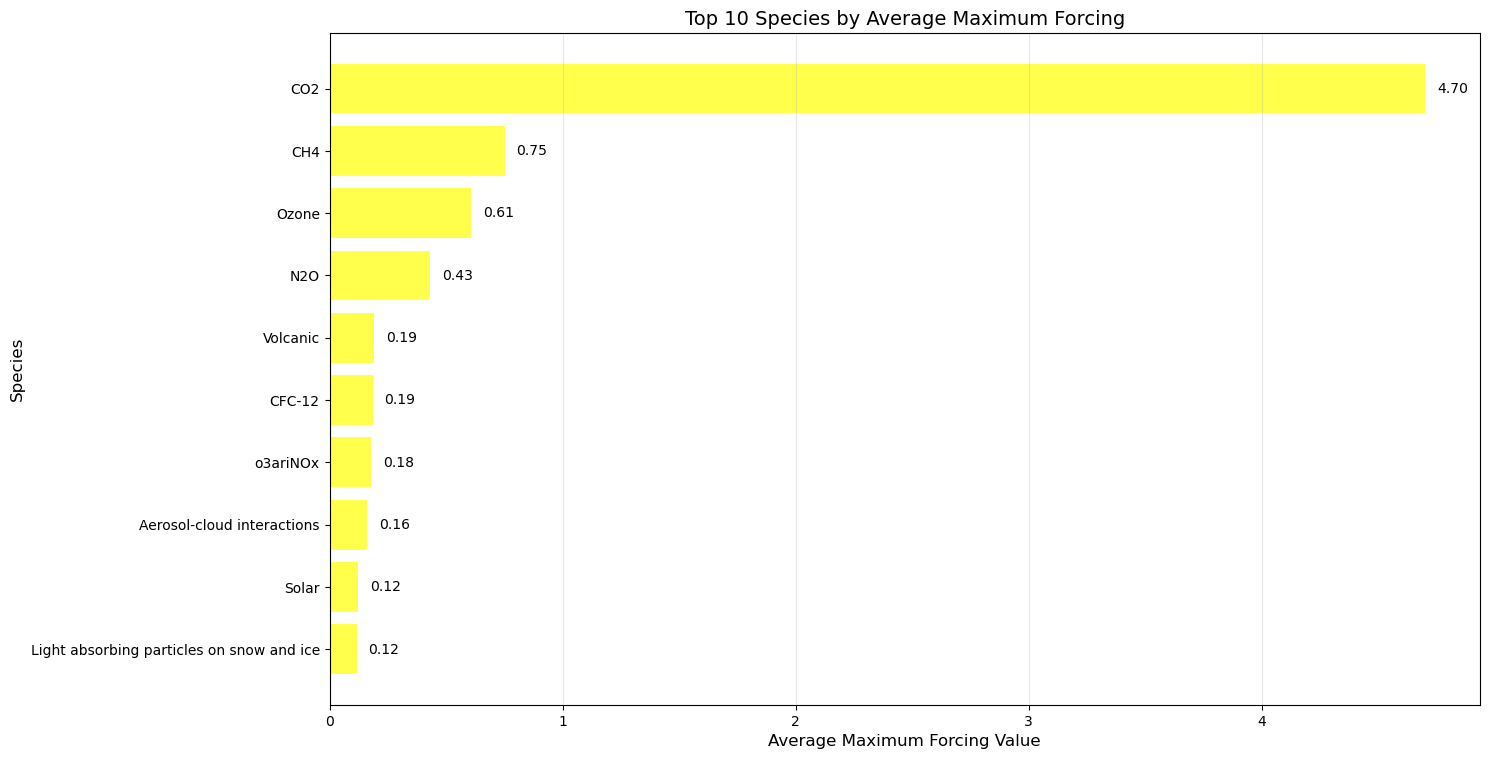

In [93]:
def plot_top(ploting_df, top_number):
    if top_number > ploting_df.nunique()['specie']:
        top_number = ploting_df.nunique()['specie']

    top_species = ploting_df.groupby('specie')['mean_max_forcing'].mean().nlargest(top_number).sort_values(ascending=True)

    pl.figure(figsize=(15, top_number/1.3))
    bars = pl.barh(top_species.index, top_species.values, color='yellow', alpha=0.7)
    pl.xlabel('Average Maximum Forcing Value', fontsize=12)
    pl.ylabel('Species', fontsize=12)
    pl.title('Top {} Species by Average Maximum Forcing'.format(top_number), fontsize=14)
    pl.grid(axis='x', alpha=0.3)

    # Add value labels
    for bar in bars:
        width = bar.get_width()
        pl.text(width + 0.05, bar.get_y() + bar.get_height()/2, f'{width:.2f}',
                 ha='left', va='center', fontsize=10)

    pl.tight_layout()
    pl.show()

plot_top(summary_df, 10)

# Ranking

Ranking:
1. Pure Maximum (Set a threshold)
2. Similar value under each scenario ( difference between each scenario)
3. Taking out 0 values

Short Set:
1. Make one with only 10 or 20
2. Look at when Maximum happening
3. Check out the long lasting forcing
4. Consider recent year range
5. Plot forcing in one year range

How species affect other species should be awared.
Include species related to Aerosal intercations

In [56]:
def ranking(forcing_df, max_threshold, cv_threshold, output_number = 100000000, dropna = False):
    if dropna:
        forcing_df = forcing_df.dropna()

    forcing_df["std_by_scenario"] = forcing_df.groupby('specie')['mean_max_forcing'].transform('std')
    forcing_df["mean_by_scenario"] = forcing_df.groupby('specie')['mean_max_forcing'].transform('mean')
    forcing_df["cv_by_scenario"] = forcing_df["std_by_scenario"]/forcing_df["mean_by_scenario"]
    forcing_df.drop(columns=["std_by_scenario", "mean_by_scenario"], inplace=True)

    forcing_df = forcing_df[forcing_df['mean_max_forcing'] > max_threshold]
    forcing_df = forcing_df[forcing_df['cv_by_scenario'] > cv_threshold]

    return forcing_df.sort_values("mean_max_forcing", ascending = False).head(output_number)

ranked_df = ranking(summary_df, 0.01, 0.1)
ranked_df

,scenario,specie,mean_max_forcing,max_forcing_std,min_year,max_year,year_range,cv_by_scenario
479,ssp585,CO2,10.566242,1.913544,2122,2250,128,0.631958
219,ssp370,CO2,7.896171,1.468144,2129,2250,121,0.631958
349,ssp460,CO2,4.461881,0.647426,2083,2234,151,0.631958
154,ssp245,CO2,3.700482,0.412594,2075,2226,151,0.631958
414,ssp534-over,CO2,3.468095,0.289793,2054,2062,8,0.631958
...,...,...,...,...,...,...,...,...
183,ssp245,SF6,0.010588,0.001189,2222,2222,0,0.553641
118,ssp126,SF6,0.010447,0.001173,2226,2226,0,0.553641
53,ssp119,SF6,0.010337,0.001160,2226,2226,0,0.553641
493,ssp585,HFC-245fa,0.010186,0.001144,2095,2095,0,0.863546


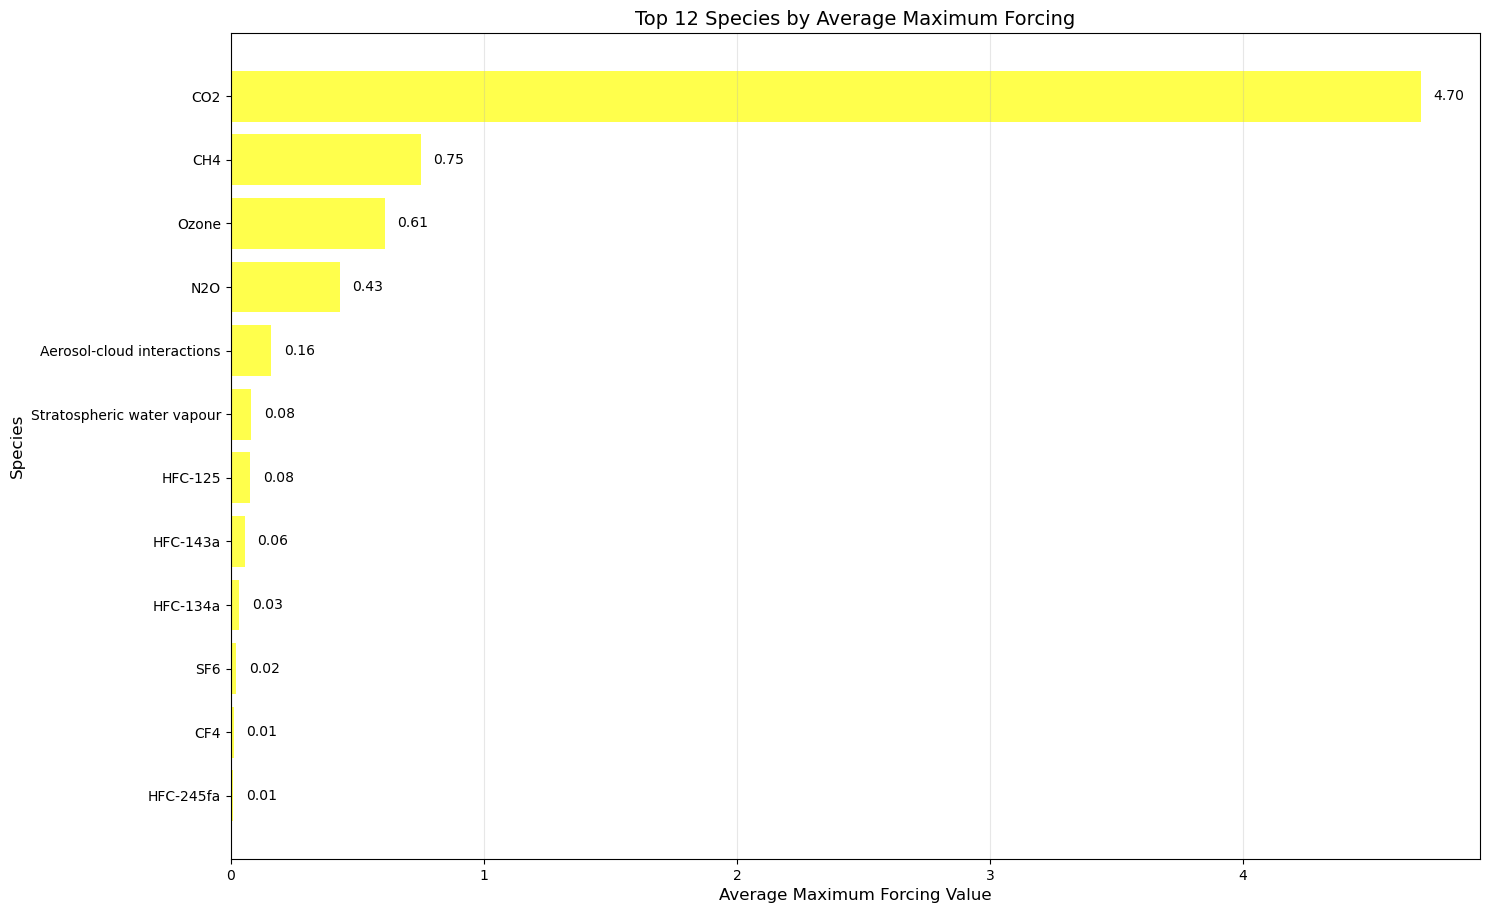

In [94]:
plot_top(ranked_df, 20)

# (unused)Max Forcing Calculation

In [ ]:
def array_to_dict(specie_array, scenario_array):
    output = {}
    index = 0
    for scenario in scenario_array:
        output[scenario] = specie_array[:, index, :]
        index += 1
    return output

ariNH3_dict = array_to_dict(ariNH3, scenarios_Rcimp)
o3CO_dict = array_to_dict(o3CO, scenarios_Rcimp)
o3VOC_dict = array_to_dict(o3VOC, scenarios_Rcimp)
o3ariNOx_dict = array_to_dict(o3ariNOx, scenarios_Rcimp)

In [ ]:
def array_forcing(specie_array, scenario_array, model):
    # returns tuple of max_forcing dict, and standard deviation for each scenario
    output = {}
    std_scenario = {}
    scenario_index = 0
    for scenario in scenario_array:
        max_forcing_array = []
        max_year_array = []
        for config in range(np.shape(specie_array)[2]):
            
            max_config_forcing = specie_array[:, scenario_index, config].max()
            max_forcing_array.append(max_config_forcing)
            
            max_config_index = specie_array[:, scenario_index, config].argmax()
            max_year = model.timepoints[max_config_index]
            max_year_array.append(max_year)
            
        max_forcing_array = np.array(max_forcing_array)
        std_scenario[scenario] = float(np.std(max_forcing_array))
        output[scenario] = float(np.average(max_forcing_array)), float(min(max_year_array)), float(max(max_year_array))
        scenario_index += 1

    return output, std_scenario

# dict: {scenario: max forcing, max year min, max year max}
ariNH3_maxforcing_dict = array_forcing(ariNH3, scenarios_Rcimp, f)[0]
ariNH3_maxforcing_std = array_forcing(ariNH3, scenarios_Rcimp, f)[1]
o3CO_maxforcing_dict = array_forcing(o3CO, scenarios_Rcimp, f)[0]
o3CO_maxforcing_std = array_forcing(o3CO, scenarios_Rcimp, f)[1]
o3VOC_maxforcing_dict = array_forcing(o3VOC, scenarios_Rcimp, f)[0]
o3VOC_maxforcing_std = array_forcing(o3VOC, scenarios_Rcimp, f)[1]
o3ariNOx_maxforcing_dict = array_forcing(o3ariNOx, scenarios_Rcimp, f)[0]
o3ariNOx_maxforcing_std = array_forcing(o3ariNOx, scenarios_Rcimp, f)[1]

In [ ]:
def forcing_writein(forcing_dict, forcing_df, specie_name):
    for scenario in forcing_dict.keys():
        # Check if the combination exists
        mask = (forcing_df['scenario'] == scenario) & (forcing_df['specie'] == specie_name)
        if mask.any():
            # Update existing rows
            forcing_df.loc[mask, 'max_forcing'] = forcing_dict[scenario]
        else:
            # Create a new row
            new_row = {'scenario': scenario, 'specie': specie_name, 'max_forcing': forcing_dict[scenario]}
            forcing_df = pd.concat([forcing_df, pd.DataFrame([new_row])], ignore_index=True)
    return forcing_df



max_forcing_df_Rcimp = forcing_writein(ariNH3_maxforcing_dict, max_forcing_df_Rcimp, 'ariNH3')
max_forcing_df_Rcimp = forcing_writein(o3CO_maxforcing_dict, max_forcing_df_Rcimp, 'o3CO')
max_forcing_df_Rcimp = forcing_writein(o3VOC_maxforcing_dict, max_forcing_df_Rcimp, 'o3VOC')
max_forcing_df_Rcimp = forcing_writein(o3ariNOx_maxforcing_dict, max_forcing_df_Rcimp, 'o3ariNOx')


max_forcing_df_Rcimp.to_csv('examples/data/calibrated_constrained_ensemble/max_forcing_Rcimp.csv')
max_forcing_df_Rcimp
#max_forcing_df_Rcimp[max_forcing_df_Rcimp['specie'] == 'o3VOC']


